# <a id='toc1_'></a>[Iterative Prompt Research](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Iterative Prompt Research](#toc1_)    
  - [Data sources and their cache](#toc1_1_)    
    - [Node and Leaf definitions](#toc1_1_1_)    
      - [Eurostat - XML](#toc1_1_1_1_)    
      - [WebPage - HTML](#toc1_1_1_2_)    
      - [FileSystem - HTML](#toc1_1_1_3_)    
  - [Prompt engineering](#toc1_2_)    
    - [AI Assistant - ChatGPT](#toc1_2_1_)    
    - [Prompt generator](#toc1_2_2_)    
  - [Testing](#toc1_3_)    
    - [Definitions of text executions](#toc1_3_1_)    
    - [Test creation](#toc1_3_2_)    
      - [Eurostat queries](#toc1_3_2_1_)    
      - [Filesystem queries](#toc1_3_2_2_)    
      - [Linux filesytem queries](#toc1_3_2_3_)    
    - [Test execution](#toc1_3_3_)    
      - [Worldbank](#toc1_3_3_1_)    
      - [Filesystem](#toc1_3_3_2_)    
  - [Evaluation](#toc1_4_)    
    - [Language Invariation](#toc1_4_1_)    
    - [Look-Ahead Trends (Tabbed)](#toc1_4_2_)    
    - [Look-Ahead Trends (Inline)](#toc1_4_3_)    
    - [Token size trend](#toc1_4_4_)    
    - [Trend model-invariation](#toc1_4_5_)    
    - [Error location penalization](#toc1_4_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [65]:
## loading configuration
load_sources : bool = True
load_webpage : bool = load_sources and False
load_filesystem : bool = load_sources and True
load_eurostat : bool = load_sources and True

## execution configuration
execute_tests : bool = True

## evaluation configuration
evaluate_results : bool = False

## <a id='toc1_1_'></a>[Data sources and their cache](#toc0_)

### <a id='toc1_1_1_'></a>[Node and Leaf definitions](#toc0_)

In [66]:
from typing import List
from itertools import compress
import pickle
import os

class Node:
    def __init__(self, name : str, predecessor : 'Node' = None, alternative_name : str = None):
        self.name = name
        self.predecessor = predecessor
        self.alternative_name : str = alternative_name
        self.children : List['Node'] = []
        self.is_active : bool = True

    def get_child(self, index : int):
        if (index >= len(self.children)):
            assert IndexError
        return self.children[index]
    
    def add_children(self, children : List['Node']):
        for child in children:
            child.predecessor = self
            self.children.append(child)

    def number_of_children(self) -> int:
        return len(self.children)
    
    def number_of_active_children(self) -> int:
        return sum(1 for child in self.children if child.is_active)

    def __str__(self) -> str:
        return f"{self.name}, #children: {len(self.children)}"
    
    def __repr__(self) -> str:
        return self.__str__()

class Leaf(Node):
    def __init__(self, name : str, predecessor : 'Node' = None, alternative_name : str = None):
        super().__init__(name, predecessor, alternative_name)
    
    def __str__(self) -> str:
        return f"{self.name}"
    
class CorrectPath:
    def __init__(self, root : Node, query : str, child_sequences : List[List['int']]):
        ## sequence must be given in reversed order, having the first move at the last position
        self.root = root
        self.current_node = root
        self.query = query
        self.child_sequences = child_sequences 
        self.__current_step = 0
        self.__available_sequences : List['bool'] = [True for _ in child_sequences]
    
    def is_next_move_correct(self, move_index : int) -> bool:
        if (all(self.__current_step >= len(sequenece) for sequenece in compress(self.child_sequences, self.__available_sequences))): return False
        if (any(move_index == sequence[self.__current_step] and self.current_node.get_child(sequence[self.__current_step]).is_active for sequence in compress(self.child_sequences, self.__available_sequences))): return True
        else: return False
        
    def make_correct_step(self, move_index : int) -> Node | None:
        self.__available_sequences = [(self.__current_step < len(sequence) and sequence[self.__current_step] == move_index) for sequence in self.child_sequences]
        if not any(self.__available_sequences): return None
        self.current_node = self.current_node.get_child(move_index)
        self.__current_step += 1
        return self.current_node
    
    def get_any_correct_step_index(self) -> int | None:
        if (self.is_at_the_end()): return None
        self.__available_sequences = [(self.__current_step < len(sequence)) for sequence in self.child_sequences]
        if not any(self.__available_sequences): return None
        return next(compress(self.child_sequences, self.__available_sequences))[self.__current_step]
    
    def is_at_the_end(self) -> bool:
        return any(self.__current_step >= len(sequence) for sequence in compress(self.child_sequences, self.__available_sequences))
    
    def shortest_path(self) -> int:
        return min(len(sequence) for sequence in self.child_sequences)
    
    def reset(self):
        self.current_node = self.root
        self.__current_step = 0
        self.__available_sequences = [True for _ in self.child_sequences]

def create_test_sequence(root : Node, query : str, child_sequences_str : List['str']) -> 'CorrectPath':
    child_sequences = [[int(x) for x in child_sequence_str.split()] for child_sequence_str in child_sequences_str]
    return CorrectPath(root, query, child_sequences)

#### <a id='toc1_1_1_1_'></a>[Eurostat - XML](#toc0_)

In [67]:
import xml.etree.ElementTree as ET

worldbank_namespaces =  {
        'nt': 'urn:eu.europa.ec.eurostat.navtree'
    }

def parse_worldbank_xml(path : str, language : str = "en") -> Node:
    """Parses the xml tree from the given path and returns the root node. Language can be 'en' or 'de'"""
    tree = ET.parse(path)
    root = tree.getroot()
    dataset : Node = Node("Eurostat")
    dataset.add_children(get_node_children(root, dataset, language))
    return dataset

def get_node_children(root : ET.Element, predecessor_node : Node, language : str) -> List['Node']:
    """Parses the given root node and returns the corresponding DataSet object."""
    datasets = []
    for branch in root.findall('nt:branch', worldbank_namespaces):
        title = branch.find(f'nt:title/[@language="{language}"]', worldbank_namespaces).text
        branch_dataset = Node(title, predecessor_node)
        for child in branch.findall('nt:children', worldbank_namespaces):
            branch_dataset.children = get_node_children(child, branch_dataset, language)
        datasets.append(branch_dataset)

    for leaf in root.findall('nt:leaf', worldbank_namespaces):
        title = leaf.find(f'nt:title/[@language="{language}"]', worldbank_namespaces).text
        datasets.append(Leaf(title, predecessor_node))

    return datasets

In [68]:
eurostat_en : Node = None
eurostat_de : Node = None

if (load_eurostat):
    if (os.path.exists("eurostat-de.pkl")):
        eurostat_en = pickle.load(open("eurostat-de.pkl", "rb"))
    else:
        eurostat_en = parse_worldbank_xml("worldBank_content.xml", "de")
        pickle.dump(eurostat_en, open("eurostat-de.pkl", "wb"))

    if (os.path.exists("eurostat-en.pkl")):
        eurostat_de = pickle.load(open("eurostat-en.pkl", "rb"))
    else:
        eurostat_de = parse_worldbank_xml("worldBank_content.xml", "en")
        pickle.dump(eurostat_de, open("eurostat-en.pkl", "wb"))

eurostat_en
eurostat_de

Eurostat, #children: 3

#### <a id='toc1_1_1_2_'></a>[WebPage - HTML](#toc0_)

In [69]:
from typing import Dict
from bs4 import BeautifulSoup
from copy import deepcopy
import requests
import time
import re

SLEEP_TIME = 5
TIMEOUT = 5
DEPTH = 5
ATTEMPTS_COUNT = 3

def parse_html_webpage(path : str) -> Node:
    """Parses the html webpage into a tree and returns the root node."""
    dataset = Node("MFF home page", None, path)
    dataset.add_children(get_html_children(dataset, DEPTH, base_url=path))
    return dataset

def get_html_children(predecessor_node : Node, remaining_depth : int, cache : Dict[tuple[str, int], Node] = {}, base_url : str | None = None) -> List['Node']:
    """Parses the given soup and returns the corresponding DataSet object."""
    """If item found in the cachce, it will be returned from there. Key of the cache is the url and the remaining depth."""
    """I can always cut the depth of the children to the required level, but I cannot expand the children if the depth is not enough."""
    child_webpages = []
    if (remaining_depth <= 0): return child_webpages

    attempt_count = 0
    page : requests.Response = None
    soup : BeautifulSoup = None
    while (attempt_count < ATTEMPTS_COUNT):
        try:
            page = requests.get(predecessor_node.alternative_name, timeout=TIMEOUT)
            soup = BeautifulSoup(page.content, 'html.parser')
            break
        except Exception as e:
            print(f"Attempt {attempt_count} failed. Error: {e}. Going to sleep for {SLEEP_TIME} seconds...")
            time.sleep(SLEEP_TIME)
        finally:
            attempt_count += 1
    
    if (page == None): return child_webpages
    
    for link in soup.find_all('a'):
        if ('href' in link.attrs and link.text.strip() != '' and not url_is_blacklisted(link.attrs['href'], base_url)):
            url = url_get_absolute(link.attrs['href'], predecessor_node.alternative_name)
            ## check if any key with same or higher depth_remaining is in the cache
            key : tuple[str,int] = (url, next((x for x in range(remaining_depth-1, DEPTH, 1) if (url, x) in cache), None))
            if (key[1] is not None): ## if anything found in the cache
                branch_dataset = cache[key] ## take the cached item
                cut_children_depth(branch_dataset, remaining_depth-1) ## cut the depth to the required level
                # branch_dataset.predecessor = predecessor_node ## set the predecessor
                branch_dataset.alternative_name = url ## set the alternative name to its url
            else:
                title = re.sub('[\\n\\s]+',' ',link.text.strip())
                branch_dataset = Node(title, predecessor_node, url) ## create new item
                if (any(k[0] == url and k[1] < remaining_depth for k in cache.keys())):
                    cache = {k:v for k,v in cache.items() if k[0] != url or k[1] > remaining_depth}
                cache[(url, remaining_depth-1)] = branch_dataset
                branch_dataset.add_children(get_html_children(branch_dataset, remaining_depth - 1, cache, base_url)) ## expand the children
                ## remove all chached items with same url and lower depth
            child_webpages.append(branch_dataset) ## add to the children response
    return child_webpages

def url_is_blacklisted(url : str, base_url : str | None = None) -> bool:
    """Checks if the url is blacklisted. Blacklist is very basic."""
    ## keep relatives
    if (url.startswith('./') or (url != "/" and url.startswith('/'))):
        return False
    
    ## filter out some basic stuff
    ## also filter those with different base url if given
    if (url == "/" 
        or url.startswith('#') 
        or url.startswith('mailto:') 
        or url.startswith('javascript:')
        or url.startswith('tel:')
        or (base_url is not None and not url.startswith(base_url))):
        return True

    ## passed
    return False

def url_get_absolute(input : str, current_url : str | None) -> str:
        """Tries to merge the relative input url with the current url prefix to get the absolute url. 
        If no current url is provided, the input is returned."""
        result = ""
        
        if (current_url is None): return input
        ## remove the query string from the url
        if ('?' in current_url): current_url = current_url.split('?')[0]
        ## remove any anchors from the url
        if ('#' in input): input = input.split('#')[0]

        ## try to cut as much from the current url as possible
        if (input.startswith('/')): 
            current_split = [x for x in current_url.split('/') if x != '']
            input_split = [x for x in input.split('/') if x != '']
            for i in range(len(current_split)):
                if (len(input_split) == 0): return current_url
                if (current_split[i] == input_split[0]): input_split.pop(0)
            input = '/'.join(input_split)

            if (current_url.endswith('/')): result = current_url + input
            else: result = current_url + '/' + input
        ## just append the relative to the current
        elif (input.startswith('./')): result = current_url + input.strip('./')
        ## otherwise legit URL given
        else: result = input
        ## always add the trailing slash if not present
        if (not result.endswith('/') and not "." in result.split('/')[-1]): ## only except if file is given
            result += '/'

        return result

def cut_children_depth(node : Node, depth : int):
    """Cuts the tree depth to the given depth."""
    if (depth <= 0):
        node.children = []
        return
    for child in node.children:
        cut_children_depth(child, depth - 1)

In [70]:
webpage : Node = None

if (load_webpage):
    if (os.path.exists("webpage.pkl")):
        webpage = pickle.load(open("webpage.pkl", "rb"))
    else:
        webpage = parse_html_webpage("https://www.mff.cuni.cz/")
        pickle.dump(webpage, open("webpage.pkl", "wb"))

webpage

#### <a id='toc1_1_1_3_'></a>[FileSystem - HTML](#toc0_)

In [71]:
from bs4 import BeautifulSoup
from collections import deque

def parse_html_file(path : str) -> Node:
    """Parses the html file into a tree and returns the root node."""
    with open(path, 'r', encoding="utf-8") as file:
        soup = BeautifulSoup(file, 'html.parser', from_encoding="utf-8")
        return get_html_file_children(soup)
    
def get_html_file_children(soup : BeautifulSoup) -> Node:
    stack = deque()
    initial_node : Node = None
    previous_node : Node = None
    for link in soup.find_all('a'):
        if ('href' in link.attrs and link.text.strip() != '' and link.attrs['href'] != "LinuxMachine"):
            url : str = link.attrs['href']
            dir : str = url[:url.rindex('/')]
            file : str = url[url.rindex('/')+1:]
            text : str = link.text.strip()

            if (initial_node is None):
                initial_node = Node(text, None, dir)
                previous_node = initial_node
                continue

            if (file == "" and  dir.startswith(previous_node.alternative_name)): ## when the file is empty, it is a directory
                current_node = Node(text, previous_node, dir)
                previous_node.children.append(current_node)
                stack.append(previous_node)
                previous_node = current_node
            elif (file != "" and dir.startswith(previous_node.alternative_name)): 
                previous_node.children.append(Leaf(text, previous_node, dir))
            else:
                while (len(stack) > 0 and not dir.startswith(previous_node.alternative_name)):
                    previous_node = stack.pop()
                if (file == ""): ## when the file is empty, it is a directory
                    current_node = Node(text, previous_node, dir)
                    previous_node.children.append(current_node)
                    stack.append(previous_node)
                    previous_node = current_node
                elif (file != "" and dir.startswith(previous_node.alternative_name)): 
                    previous_node.children.append(Leaf(text, previous_node, dir))
    return initial_node

In [72]:
filesystem : Node = None
linux_filesystem : Node = None

if (load_filesystem):
    if (os.path.exists("filesystem.pkl")):
        filesystem = pickle.load(open("filesystem.pkl", "rb"))
    else:
        filesystem = parse_html_file("filesystem_content.html")
        pickle.dump(filesystem, open("filesystem.pkl", "wb"))

    if (os.path.exists("linux_filesystem.pkl")):
        linux_filesystem = pickle.load(open("linux_filesystem.pkl", "rb"))
    else:
        linux_filesystem = parse_html_file("linux_filesystem_content.html")
        pickle.dump(linux_filesystem, open("linux_filesystem.pkl", "wb"))

filesystem
linux_filesystem

bin, #children: 21

## <a id='toc1_2_'></a>[Prompt engineering](#toc0_)

### <a id='toc1_2_1_'></a>[AI Assistant - ChatGPT](#toc0_)

In [73]:
from openai import OpenAI
from openAI_secret import API_KEY
from consts import MODEL

class OpenAIWrapper:
    def __init__(self, keep_whole_context : bool, system_message : str):
        self.client = OpenAI(api_key=API_KEY)
        self.keep_whole_context = keep_whole_context
        self.system_message = system_message
        self.messages = [self.__create_system_message(self.system_message)]
        self.tokens_used = 0
        self._last_response_token_size = 0

    def get_tokens_used(self) -> int:
        """Returns the number of tokens used. 
        Also adds the tokens from the last prompt that has been sent, 
        since the last response is not counted otherwise."""
        if (self.keep_whole_context):
            return self._last_response_token_size
        
        self.tokens_used += self._last_response_token_size
        self._last_response_token_size = 0
        return self.tokens_used
    
    def reset_tokens_used(self):
        """Resets the token counter."""
        self.tokens_used = 0
        self._last_response_token_size = 0

    def __create_user_message(self, content):
        return {"role": "user", "content": content}
    
    def __create_system_message(self, content):
        return {"role": "system", "content": content}
    
    def __create_assistant_message(self, content):
        return {"role": "assistant", "content": content}
    
    def __add_message(self, content):
        if (self.keep_whole_context):
            self.messages.append(self.__create_user_message(content))
        else:
            self.tokens_used += self._last_response_token_size ## count the previous prompt
            self._last_response_token_size = 0 ## clear for current
            self.messages = [
                self.__create_system_message(self.system_message),
                self.__create_user_message(content) 
            ]

    def __get_response(self):
        full_response = self.client.chat.completions.create(
            model = MODEL,
            messages=self.messages,
            temperature=0,
            timeout=30
        )

        self._last_response_token_size = full_response.usage.total_tokens
        response_content = full_response.choices[-1].message.content
        self.messages.append(self.__create_assistant_message(response_content))
        return response_content
    
    def get_response_to_prompt(self, prompt) -> str:
        """Gets the assistant response to the given prompt. Depeneding on the \"keep_whole_context\" setting, the whole context is kept or just the current prompt is given to the assistant."""
        self.__add_message(prompt)
        response = self.__get_response()
        # for message in self.messages:
        #     print(f"{message['content']}")
        return response if response is not None else ""
    
    def get_additional_response(self, prompt) -> str:
        """Gets a response to the given prompt, but regardless of the \"keep_whole_context\" setting, the previous context is kept."""
        self.messages.append(self.__create_user_message(prompt))
        # for message in self.messages:
        #     print(f"{message['content']}")
        return self.__get_response()

### <a id='toc1_2_2_'></a>[Prompt generator](#toc0_)

In [74]:
from nltk.stem.snowball import SnowballStemmer
from consts import *

class AssistantWorker:
    def __init__(self, stemmer : SnowballStemmer, look_ahead_depth : int = 1):
        self.stemmer = stemmer
        self.look_ahead_depth = look_ahead_depth
        print(MODEL)
        pass

    def create_llm_query(self, initial_query : str, path_done : List['Node'], current_node : Node, mode : int) -> str:
        """Creates a query for the LLM model based on the current node."""
        next_moves = []
        prompt = ""
        steps_so_far = " -> ".join([node.name for node in path_done])

        match mode:
            case WORKER_MODE.STEP_BY_STEP | WORKER_MODE.MATCH_AND_FILTER:
                next_moves = [f"\t{i}: {child.name}\n" for i, child in enumerate([child for child in current_node.children if child.is_active])]
                prompt = (
                f"query: {initial_query}\n"
                f"steps done: {steps_so_far}\n"
                f"next possible subsection names:\n"
                f"{''.join(next_moves)}"
                )
            case WORKER_MODE.LOOK_AHEAD | WORKER_MODE.LOOK_AHEAD_INLINE:
                for i, child in enumerate([child for child in current_node.children if child.is_active]):
                    if (mode == WORKER_MODE.LOOK_AHEAD_INLINE):
                        next_moves.append(f"\t{i}: {self.create_look_ahead_inline_prompt(child, self.look_ahead_depth-1)}\n")    
                    else:
                        next_moves.append(f"{i}: {self.create_look_ahead_prompt(child, self.look_ahead_depth-1, self.look_ahead_depth-1)}")
                prompt = (
                f"query: {initial_query}\n"
                f"steps done: {steps_so_far}\n"
                f"next possible subsection names:\n"
                f"{''.join(next_moves)}"
                )
            case WORKER_MODE.KEYWORD_GEN_AND_MATCH:
                prompt = (
                f"query: {initial_query}\n"
                f"For the query above, please write {NUM_OF_KEYWORDS} keywords that might be relevant names of subsections to dive into in an upcoming search. Prefere single words. Use the language of the query!\n"
                f"Please separate the keywords with semicolon. Dont write anything else!\n"
                )

        return prompt
    
    def create_llm_nonint_message(self) -> str:
        """Creates a message for the user when the answer was not an integer."""
        response = f"You must only return integer, for example 3. If you don't know the answer, return -1"
        return response
    
    def create_llm_wrong_answer_message(self) -> str:
        """Creates a message for the user when the answer was not correct."""
        response = f"Your answer was not correct. Please try another one."
        return response

    def process_llm_child_pick_response(self, raw_response : str) -> int | None:
        """Returns the child index of the llm decision. -1 means the assistant thinks it is the end already, returns NONE if non-digit answer given."""
        response = raw_response.strip()

        if (response == "-1"):
            return -1
        
        if not response.isdigit():
            return None
        else:
            try:
                int_response = int(response)
                return int_response
            except:
                return None

    def process_llm_keyword_gen_response(self, raw_response : str) -> List['str']:
        return [self.stemmer.stem(x.strip().casefold()) for x in raw_response.split(";")]
    
    def create_look_ahead_prompt(self, child : Node, depth_total : int, depth_remaining : int) -> str:
        tab = '\t'
        newline = '\n'
        prompt = f"{''.join([tab for _ in range(depth_total - depth_remaining)])}- {child.name}{newline}"
        
        if depth_remaining == 0:
            return prompt
        
        for i, grandchild in enumerate(child.children):
            prompt += f"{self.create_look_ahead_prompt(grandchild, depth_total, depth_remaining - 1)}"
        return prompt
    
    def create_look_ahead_inline_prompt(self, child : Node, depth_remaining : int) -> str:
        prompt = f"{child.name}"
        if (depth_remaining >= 1):
            prompt += "("
            for grandchild in child.children:
                prompt += f"{self.create_look_ahead_inline_prompt(grandchild, depth_remaining - 1)}, "
            prompt = prompt.strip(", ")
            prompt += ")"
        return prompt

## <a id='toc1_3_'></a>[Testing](#toc0_)

### <a id='toc1_3_1_'></a>[Definitions of text executions](#toc0_)

In [75]:
from typing import List, Dict
import numpy as np

REPETITION_COUNT = 10

class TestResult:
    def __init__(self):
        self.__steps_taken = 0
        self.__wrong_moves = 0
        self.__non_int_responses = 0
        self.__assisted_answers = 0
        self.sucess = False

    @property
    def steps_taken(self):
        return self.__steps_taken

    @steps_taken.setter
    def steps_taken(self, value):
        self.__steps_taken = value

    @property
    def wrong_moves(self):
        return self.__wrong_moves

    @wrong_moves.setter
    def wrong_moves(self, value):
        self.__wrong_moves = value

    @property
    def non_int_responses(self):
        return self.__non_int_responses

    @non_int_responses.setter
    def non_int_responses(self, value):
        self.__non_int_responses = value

    @property
    def assisted_answers(self):
        return self.__assisted_answers

    @assisted_answers.setter
    def assisted_answers(self, value):
        self.__assisted_answers = value

    def mark_wrong_move(self):
        """Adds a wrong move to the result. Also increases the steps taken by 1."""
        self.steps_taken += 1
        self.wrong_moves += 1

    def mark_non_int_responses(self):
        """Adds a non-integer response to the result. Also increases the steps taken by 1."""
        self.steps_taken += 1
        self.non_int_responses += 1

    def mark_correct_move(self):
        """Increases the steps taken by 1."""
        self.steps_taken += 1

    def mark_assisted_answer(self):
        """Adds an assisted answer to the result."""
        self.assisted_answers += 1

    def __str__(self) -> str:
        return f"{'Passed' if self.sucess else 'Failed'}, steps: {self.__steps_taken}, wrong: {self.__wrong_moves}, non-int: {self.__non_int_responses}, assisted: {self.__assisted_answers}, score: {self.get_score()*100:.2f}%"
    
    def __repr__(self) -> str: return self.__str__()

    def get_score(self) -> float:
        """Returns a number in range <0,1> where 1 is the best result."""
        return 1 - (self.__wrong_moves / self.__steps_taken)


class TestResultExtended(TestResult):
    class AnswerSegment(TestResult):
        def __init__(self):
            super().__init__()
        
        def get_score(self) -> np.ndarray[int]:
            """Returns number of: steps_taken, wrong moves, non_int_answers and assisted answers in np.array"""
            return np.array([self.steps_taken, self.wrong_moves, self.non_int_responses, self.assisted_answers], dtype=int)

    def __init__(self):
        """Extended definition of TestResults. Keeps the same API functions, but splits the steps into segments corresponding to each correct step from the 'CorrectPath'. Enables to evaluate the results based on where in the decision tree the mistake happened."""
        super().__init__()
        self.segments : List['TestResultExtended.AnswerSegment'] = [TestResultExtended.AnswerSegment()]
        self.__current_segment_index : int = 0
        self.__score : None | float = None
        self.tokens_used : int | None = None

    def set_tokens_used(self, tokens_used : int):
        """Saves the number of tokens used in the current test.
        Was added later, therefore None is the default value in the constructor."""
        self.tokens_used = tokens_used

    def __current_segment(self) -> 'TestResultExtended.AnswerSegment':
        return self.segments[self.__current_segment_index]
    
    def mark_wrong_move(self):
        """Adds a wrong move to the result. Also increases the steps taken by 1."""
        self.__current_segment().steps_taken += 1
        self.__current_segment().wrong_moves += 1

    def mark_non_int_responses(self):
        """Adds a non-integer response to the result. Also increases the steps taken by 1."""
        self.__current_segment().steps_taken += 1
        self.__current_segment().non_int_responses += 1

    def mark_correct_move(self):
        """Increases the steps taken by 1."""
        self.__current_segment().steps_taken += 1
        self.segments.append(TestResultExtended.AnswerSegment())
        self.__current_segment_index += 1

    def mark_assisted_answer(self):
        """Adds an assisted answer to the result."""
        self.__current_segment().assisted_answers += 1
        self.segments.append(TestResultExtended.AnswerSegment())
        self.__current_segment_index += 1
    
    def evaluate_score(self, penalizations : List[float] = [1.0]) -> None:
        num_of_penalization_segments = len(penalizations)
        num_of_segments = len(self.segments)
        total_score_unnormalized = 0
        total_normalization = 0

        assert num_of_segments > 0, "No segments found in the TestResultExtended object."
        assert num_of_penalization_segments > 0, "No penalization given!"

        if (self.segments[-1].steps_taken == 0):
            self.segments.pop() ## remove the last unused step if exists
        
        ## restart the counters before calling score function
        self.steps_taken = 0
        self.wrong_moves = 0
        self.non_int_responses = 0
        self.assisted_answers = 0

        for i, segment in enumerate(self.segments):
            ## make the regular stats for final print
            score = segment.get_score()
            self.steps_taken += score[0]
            self.wrong_moves += score[1]
            self.non_int_responses += score[2]
            self.assisted_answers += score[3]
            ## make penalization
            penalization_index = int(i/(num_of_segments/num_of_penalization_segments)) ## takes the current penalization
            total_normalization += score[0]*penalizations[penalization_index]
            total_score_unnormalized += score[1]*penalizations[penalization_index]
            
        self.__score = 1 - (total_score_unnormalized / total_normalization)

    def get_score(self) -> float:
        assert self.__score is not None, "The score was not evaluated yet. Call evaluate_score() first."
        return self.__score
    
    def __str__(self) -> str:
        return f"Steps: {self.steps_taken}, wrong: {self.wrong_moves}, non-int: {self.non_int_responses}, assisted: {self.assisted_answers}, score: {self.get_score()*100:.2f}%"

class TestRunner:
    def __init__(self, stemmer : SnowballStemmer):
        self.stemmer = stemmer
        
    def execute(self, tests : List['CorrectPath'], openai : OpenAIWrapper, worker : AssistantWorker, mode : int, name : str):
        ## name = "source_any-option_model_prompt-method_result_date"
        results : List['TestResultExtended'] = []
        for repetition in range(REPETITION_COUNT):
            for i, test in enumerate(tests):
                print(f"Runing test {i} ({repetition+1}/{REPETITION_COUNT})...")
                test.reset()
                openai.reset_tokens_used()
                result = self.__run(test.current_node, test.query, worker, openai, test, mode)
                results.append(result)

                ## get the linear score of the result
                if (type(result) == TestResultExtended):
                    result.evaluate_score()

                result.get_score()

                if (type(result) == TestResultExtended and result.tokens_used is not None):
                    print(f"\tTest {i}: {result} Tokens used: {result.tokens_used}")
                else:
                    print(f"\tTest {i}: {result}")
            print("---------------------")
            print("Saving the results...")
            pickle.dump(results, open(f"{name}_{repetition+1}.pkl", "wb"))
            results = []

    def __run(self, root : Node, query : str, worker : AssistantWorker, openai : OpenAIWrapper, correct_path : CorrectPath, mode : int) -> TestResult:
        path_done : List['Node'] = []
        current_node = root
        result : TestResultExtended = TestResultExtended()
        keywords : List[str] = []
        index_translation : Dict[int, int] = {}
        work_mode = mode
        if (mode == WORKER_MODE.KEYWORD_GEN_AND_MATCH):
            keywords = worker.process_llm_keyword_gen_response(openai.get_response_to_prompt(worker.create_llm_query(query, path_done, current_node, mode)))
        
        while (True):
            if (mode == WORKER_MODE.KEYWORD_GEN_AND_MATCH):
                current_node, index_translation = self.__reduce_node(current_node, keywords)
                correct_path.current_node = current_node
                work_mode = WORKER_MODE.STEP_BY_STEP

            if (current_node.number_of_active_children() == 0 and not correct_path.is_at_the_end() and mode == WORKER_MODE.KEYWORD_GEN_AND_MATCH):
                result.mark_wrong_move()
                result.mark_assisted_answer()
                current_node = correct_path.make_correct_step(correct_path.get_any_correct_step_index())
            else:
                prompt = worker.create_llm_query(query, path_done, current_node, work_mode)
                next_child_index = worker.process_llm_child_pick_response(openai.get_response_to_prompt(prompt))
                if (next_child_index is None):
                    result.mark_non_int_responses()
                    additional_prompt = worker.create_llm_nonint_message()
                    next_child_index = worker.process_llm_child_pick_response(openai.get_additional_response(additional_prompt))
                    if (next_child_index is None):
                        result.mark_non_int_responses()
                        result.sucess = False
                        break
                    else:
                        should_break, next_child_index = self.__process_valid_response(next_child_index, result, worker, openai, correct_path, path_done, current_node.number_of_active_children(), index_translation)
                        if (should_break): break
                else:
                    should_break, next_child_index = self.__process_valid_response(next_child_index, result, worker, openai, correct_path, path_done, current_node.number_of_active_children(), index_translation)
                    if (should_break): break

                ## continue to the next node
                # print("-----")
                # print(f"Messages: ")
                # for message in openai.messages:
                #     print(f"{message['role']} : {message['content']}")
                # print(f"Next child: {next_child_index}")
                current_node = correct_path.make_correct_step(next_child_index)
                # print("-----")

            if (correct_path.is_at_the_end()):
                result.sucess = True
                break
            else:
                path_done.append(current_node)

        result.set_tokens_used(openai.get_tokens_used())
        return result
    
    def __process_valid_response(self, next_child_index : int, result : TestResult, worker : AssistantWorker, openai : OpenAIWrapper, correct_path : CorrectPath, path_done : List['Node'], max_num_of_entries : int, index_translations : Dict['int', 'int'] = {}) -> tuple[bool, int]:
        index_translated : bool = False
        max_num_of_tries : int = 4 ## empiric value
        if (index_translations != {} and next_child_index != -1 and next_child_index < correct_path.current_node.number_of_active_children()):
            index_translated = True
            next_child_index = index_translations[next_child_index]
            
        if (correct_path.is_at_the_end()): ## when already at the end
            if (next_child_index == -1): ## if the assistant knows it is the end
                result.mark_correct_move()
                result.sucess = True
                return (True, -1)
            else: ## if the assistant doesn't know it is the end
                result.mark_wrong_move()
                result.sucess = False
                return (True, -1)
        else:
            num_of_tries = 1
            while (
                (not index_translated and next_child_index >= correct_path.current_node.number_of_active_children()) 
                or (not correct_path.is_next_move_correct(next_child_index) and num_of_tries <= min(max_num_of_entries, max_num_of_tries))
                ):
                index_translated = False
                result.mark_wrong_move()
                wrong_response_prompt = worker.create_llm_wrong_answer_message()
                next_child_index = worker.process_llm_child_pick_response(openai.get_additional_response(wrong_response_prompt))
                if (next_child_index is None):
                    result.mark_non_int_responses()
                    additional_prompt = worker.create_llm_nonint_message()
                    next_child_index = worker.process_llm_child_pick_response(openai.get_additional_response(additional_prompt))
                    if (next_child_index is None):
                        result.mark_non_int_responses()
                        result.mark_assisted_answer()
                        return (False, correct_path.get_any_correct_step_index())
                    else:
                        if (index_translations != {} and next_child_index != -1 and next_child_index < correct_path.current_node.number_of_active_children()):
                            index_translated = True
                            next_child_index = index_translations[next_child_index]
                else:
                    if (index_translations != {} and next_child_index != -1 and next_child_index < correct_path.current_node.number_of_active_children()):
                        index_translated = True
                        next_child_index = index_translations[next_child_index]
                num_of_tries += 1

            if (correct_path.is_next_move_correct(next_child_index)):
                result.mark_correct_move()
                return (False, next_child_index)
            else:
                result.mark_wrong_move()
                result.mark_assisted_answer()
                return (False, correct_path.get_any_correct_step_index())
            
    def __reduce_node(self, node : Node, keywords : List['str']) -> tuple[Node, Dict['int', 'int']]:
        """Reduces the tree based on the given keywords."""
        ## make copy of the node
        reduced_node = deepcopy(node)
        translation = {}
        reduced_index = 0
        for i, child in enumerate(reduced_node.children):
            if (self.__is_relevant(child, keywords)):
                translation[reduced_index] = i
                reduced_index += 1
            else:
                child.is_active = False
        return reduced_node, translation

    def __is_relevant(self, node : Node, keywords : List['str']) -> bool:
        """Checks if the given node is relevant based on the given keywords."""
        return any(keyword in self.stemmer.stem(node.name.strip().casefold()) for keyword in keywords)


### <a id='toc1_3_2_'></a>[Test creation](#toc0_)

#### <a id='toc1_3_2_1_'></a>[Eurostat queries](#toc0_)
Every test contains a source, a user (human friendly) query to which should be the relevant database table found and a list of sequences of indexes (zero based) that lead to the correct table.

The table of content of whole eurostat database was gathered at February 2024 and is saved locally.

When deciding, whether the current path of the assistant is correct, any matching correct sequence will satisfy. All other sequences that are not following the same path are removed at the first node with a mismatch.
At every step with **N** options, the assistant can take up to **N** steps. The assistant should get to the correct node with the lowest number of steps taken.

In [76]:
eurostat_tests_english = [
    create_test_sequence(eurostat_en, "What was the GDP growth rate for Czech Republic in 2019?", [
        "0 1 0 0 0 0"]),
    create_test_sequence(eurostat_en, "How many people lived in Germany in 2020?", [
        "0 2 1 1 0", "0 2 1 1 1", "0 2 1 1 2", 
        "0 2 1 1 3", "0 2 1 1 4", "0 2 1 1 5", 
        "0 2 1 1 6", "0 2 1 1 7", "0 2 1 1 8", 
        "0 2 1 1 9", "0 2 1 1 10", "0 2 1 1 11", 
        "0 2 1 1 12"]),
    create_test_sequence(eurostat_en, "What was the unemployment rate in Austria in 2015?", [
        "0 2 7 0 0 2 0", "0 2 7 0 0 2 3", "0 2 7 0 0 2 5", "0 2 7 0 0 2 0"]),
    create_test_sequence(eurostat_en, "What percentage of the population in Europe had access to clean water and sanitation facilities in 2010?", [
        "1 3 5 0"]),
    create_test_sequence(eurostat_en, "What was the government expenditure on healthcare in Poland in 2018?", [
        "0 2 4 2 0 0 0", "0 2 4 2 0 1 0"]),
    create_test_sequence(eurostat_en, "How much renewable energy was consumed as a percentage of total energy consumption in France in 2020?", [
        "0 7 1 0 0 4 0", "0 7 1 0 0 4 8"]),
    create_test_sequence(eurostat_en, "What was the green-house-gases emissions level for Spain in 2014?", [
        "0 7 0 0 0 0", "0 7 0 0 0 1", "0 7 0 0 0 5", 
        "2 6 0 0", "2 6 0 1", "2 6 0 2", "2 6 0 4"]),
    create_test_sequence(eurostat_en, "What was the inflation rate in Italy in 2018?", [
        "0 1 4 0 1", "0 1 4 0 4", "0 1 4 0 5"]),
    create_test_sequence(eurostat_en, "What was the total external debt of Czech Republic in 2021, and how does it compare to its GDP?", [
        "0 1 1 0 1 3", "0 1 1 0 1 0 0", "0 1 1 0 1 0 1", 
        "0 1 1 0 1 0 2", "0 1 1 0 1 0 7", "0 1 1 0 1 0 8", 
        "0 1 1 0 1 0 9"]),
    create_test_sequence(eurostat_en, "What was the ratio of female to male participation in the labor force in Romania in 2015?", [
        "0 2 7 0 0 0 0", "0 2 7 0 0 1 0", "0 2 7 0 2 2 0", "0 2 7 0 2 2 1", "0 2 7 0 2 2 2",
        "0 2 7 0 2 2 3", "0 2 7 0 2 2 4", "0 2 7 0 2 2 5", "0 2 7 0 2 2 6", "0 2 7 0 2 2 7",
        "0 2 7 0 2 2 8", "0 2 7 0 2 2 9", "0 2 7 0 2 2 10", "0 2 7 0 2 2 11", "0 2 7 0 2 2 12",
        "0 2 7 0 2 2 16", "0 2 7 0 2 2 17", "0 2 7 0 2 2 18", "0 2 7 0 2 2 22", "0 2 7 0 2 2 23",
        "0 2 7 0 2 3 0", "0 2 7 0 2 3 1", "0 2 7 0 2 3 2", "0 2 7 0 2 3 3", "0 2 7 0 2 3 4", "0 2 7 0 2 3 5",
        "0 2 7 0 2 5 0", "0 2 7 0 2 5 1", "0 2 7 0 2 5 2", "0 2 7 0 2 5 3", "0 2 7 0 2 5 5"])
]

eurostat_tests_german = [
    create_test_sequence(eurostat_de, "Wie hoch war die BIP-Wachstumsrate für die Tschechische Republik im Jahr 2019?", [
        "0 1 0 0 0 0"]),
    create_test_sequence(eurostat_de, "Wie viele Menschen leben im Jahr 2020 in Deutschland?", [
        "0 2 1 1 0", "0 2 1 1 1", "0 2 1 1 2", 
        "0 2 1 1 3", "0 2 1 1 4", "0 2 1 1 5", 
        "0 2 1 1 6", "0 2 1 1 7", "0 2 1 1 8", 
        "0 2 1 1 9", "0 2 1 1 10", "0 2 1 1 11", 
        "0 2 1 1 12"]),
    create_test_sequence(eurostat_de, "Wie hoch war die Arbeitslosenquote in Österreich im Jahr 2015?", [
        "0 2 7 0 0 2 0", "0 2 7 0 0 2 3", "0 2 7 0 0 2 5", "0 2 7 0 0 2 0"]),
    create_test_sequence(eurostat_de, "Welcher Prozentsatz der Bevölkerung in Europa hatte im Jahr 2010 Zugang zu sauberem Wasser und Sanitäranlagen?", [
        "1 3 5 0"]),
    create_test_sequence(eurostat_de, "Wie hoch waren die Regierungsausgaben für das Gesundheitswesen in Polen im Jahr 2018?", [
        "0 2 4 2 0 0 0", "0 2 4 2 0 1 0"]),
    create_test_sequence(eurostat_de, "Wie viel erneuerbare Energie wurde in Frankreich im Jahr 2020 verbraucht, und wie verhält sich das zum Gesamtenergieverbrauch?", [
        "0 7 1 0 0 4 0", "0 7 1 0 0 4 8"]),
    create_test_sequence(eurostat_de, "Wie hoch war der Ausstoß von Treibhausgasen für Spanien im Jahr 2014?", [
        "0 7 0 0 0 0", "0 7 0 0 0 1", "0 7 0 0 0 5", 
        "2 6 0 0", "2 6 0 1", "2 6 0 2", "2 6 0 4"]),
    create_test_sequence(eurostat_de, "Wie hoch war die Inflationsrate in Italien im Jahr 2018?", [
        "0 1 4 0 1", "0 1 4 0 4", "0 1 4 0 5"]),
    create_test_sequence(eurostat_de, "Wie hoch war die Gesamtverschuldung der Tschechischen Republik im Jahr 2021, und wie verhält sie sich zum BIP?", [
        "0 1 1 0 1 3", "0 1 1 0 1 0 0", "0 1 1 0 1 0 1", 
        "0 1 1 0 1 0 2", "0 1 1 0 1 0 7", "0 1 1 0 1 0 8", 
        "0 1 1 0 1 0 9"]),
    create_test_sequence(eurostat_de, "Was war das Verhältnis von weiblicher zu männlicher Beteiligung an der Erwerbsarbeit in Rumänien im Jahr 2015?", [
        "0 2 7 0 0 0 0", "0 2 7 0 0 1 0", "0 2 7 0 2 2 0", "0 2 7 0 2 2 1", "0 2 7 0 2 2 2",
        "0 2 7 0 2 2 3", "0 2 7 0 2 2 4", "0 2 7 0 2 2 5", "0 2 7 0 2 2 6", "0 2 7 0 2 2 7",
        "0 2 7 0 2 2 8", "0 2 7 0 2 2 9", "0 2 7 0 2 2 10", "0 2 7 0 2 2 11", "0 2 7 0 2 2 12",
        "0 2 7 0 2 2 16", "0 2 7 0 2 2 17", "0 2 7 0 2 2 18", "0 2 7 0 2 2 22", "0 2 7 0 2 2 23",
        "0 2 7 0 2 3 0", "0 2 7 0 2 3 1", "0 2 7 0 2 3 2", "0 2 7 0 2 3 3", "0 2 7 0 2 3 4", "0 2 7 0 2 3 5",
        "0 2 7 0 2 5 0", "0 2 7 0 2 5 1", "0 2 7 0 2 5 2", "0 2 7 0 2 5 3", "0 2 7 0 2 5 5"])
]

#### <a id='toc1_3_2_2_'></a>[Filesystem queries](#toc0_)

Every test contains a source and an user query to which the assistant should find the best file.
The filesystem was taken from my personal HDD drive of many documents, photos and files.
The files are not located in the same depth as in eurostat database. 
User queries were therefore made more "user-like" and less "ultra-specific".

In [77]:
filesystem_tests = [
    create_test_sequence(filesystem, "Najdi můj LocatorForm z roku 2021, který jsem potřeboval kvůli pandemii covidu pro vstup do Británie.", [
        "7 5 0"
    ]),
    create_test_sequence(filesystem, "Najdi moje potvrzení o zdanitelných přijmech z roku 2022 od firmy LOKOTRAIN.", [
        "10 1 2"
    ]),
    create_test_sequence(filesystem, "Najdi zdrojový kód projektu na zobrazení předpovědi počasí na procesor ESP32.", [
        "14 5 6 0"
    ]),
    create_test_sequence(filesystem, "Najdi můj záznam docházi v práci LokoTrain za měsíc Leden 2022.", [
        "21 1 1 5"
    ]),
    create_test_sequence(filesystem, "Najdi dokument o konstrukci asynchronního motoru z kurzu společnosti LokoTrain.", [
        "21 6 5 2"
    ]),
    create_test_sequence(filesystem, "Najdi nový formulář pro hlášení závady na lokomotivě, vyrobený pro firmu LokoTrain.", [
        "21 6 9 1"
    ]),
    create_test_sequence(filesystem, "Najdi \"lokousage\" soubor z října 2021, který reportujeme pro LokoTrain každý měsíc.", [
        "21 4 0 4"
    ]),
    create_test_sequence(filesystem, "Najdi rozpad energie od DBE pro dopravce CDC za květen 2022 vytvořený firmou LokoTrain.", [
        "21 0 6 1 4 2"
    ]),
    create_test_sequence(filesystem, "Najdi avizo o změně registrační poznávací značky na mém autě značky Škoda Octavia.", [
        "24 0"
    ]),
    create_test_sequence(filesystem, "Najdi soubor se všemi prozrazenými lidskými hesly pro penetrační testování.", [
        "28 0 0"
    ]),
    create_test_sequence(filesystem, "Najdi fakturu o koupi mého kola SpaceChicken od firmy PlanetX.", [
        "30 2 2", "30 2 3"
    ]),
    create_test_sequence(filesystem, "Najdi AutoCAD soubor s návrhem rodinného domu ve Hvězdonicích pro modelové kolejiště na Podbabě.", [
        "31 0 1"
    ]),
    create_test_sequence(filesystem, "Najdi vstupenky do musea Becherovky.", [
        "39 0"
    ]),
    create_test_sequence(filesystem, "Najdi ukázkový zdrojový soubor pro knihovnu na ovládání více tlačítek, kterou používám u projektu \"DPP TABLA\", který byl napsaný na ESP32", [
        "14 2 0 0 1 2"
    ])
]

#### <a id='toc1_3_2_3_'></a>[Linux filesytem queries](#toc0_)

In [78]:
linux_filesystem_tests = [
    create_test_sequence(linux_filesystem, "Find the directory where system service scripts are stored.", [
        "2 31 0",
        "2 81 1"
    ]),
    create_test_sequence(linux_filesystem, "Find the directory where system manual pages in czech or german are stored.", [
        "18 6 73 0", "18 6 73 2"
    ]), 
    create_test_sequence(linux_filesystem, "Find the directory where system libraries are stored. (scanned from linux 64bit machine on OrangePI3)", [
        "18 3 0"
    ]),
    create_test_sequence(linux_filesystem, "Find the directory containing system-wide startup scripts.", [
        "2 81 1 2"
    ]),
    create_test_sequence(linux_filesystem, "Find the directory where system service scripts are stored.", [
        "2 81 1 4"
    ]),
    create_test_sequence(linux_filesystem, "Find the directory containing system-wide cron jobs.", [
        "2 14 0"
    ]),
    create_test_sequence(linux_filesystem, "Find the directory where system logs are stored.", [
        "19 6 9", "19 3 9"
    ]),
    create_test_sequence(linux_filesystem, "Find the directory where Apache webserver default SSL site is stored.", [
        "2 1 4"
    ]),
    create_test_sequence(linux_filesystem, "Find the directory with default webroot html file.", [
        "19 13 5"
    ]),
    create_test_sequence(linux_filesystem, "Find the directory with logs of 'azure' application installed by user 'mecool'", [
        "3 0 0 1"
    ]),
]

### <a id='toc1_3_3_'></a>[Test execution](#toc0_)

#### <a id='toc1_3_3_1_'></a>[Worldbank](#toc0_)

In [79]:
from datetime import datetime
from consts import WORKER_MODE, MODEL
import pickle

if (execute_tests):
    system_message = "You are an assistant that is helping a user to navigate through the World Bank data.\
        You are given a query and all available subsections.\
        You should help the user to navigate to the correct subsection.\
        Answer only with the number of the subsection.\
        If you don't know the answer, return -1."
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    runner = TestRunner(stemmer)

    current_date = datetime.now().strftime("%Y-%m-%d")

    for lang in ["en"]:
        tests : List['CorrectPath'] = None
        if (lang == "en"):
            tests = eurostat_tests_english
        else:
            tests = eurostat_tests_german

        ## name = "source_any-option_model_prompt-method_result_date"
        # worker = AssistantWorker(stemmer)
        # openai = OpenAIWrapper(False, system_message)
        # runner.execute(tests, openai, worker, WORKER_MODE.STEP_BY_STEP, f"eurostat_{lang}_{MODEL}_look-ahead-1_results_{current_date}")

        worker = AssistantWorker(stemmer, look_ahead_depth=2)
        openai = OpenAIWrapper(False, system_message)
        runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD, f"eurostat_{lang}_{MODEL}_look-ahead-2_results_{current_date}")

        worker = AssistantWorker(stemmer, look_ahead_depth=3)
        openai = OpenAIWrapper(False, system_message)
        runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD, f"eurostat_{lang}_{MODEL}_look-ahead-3_results_{current_date}")

        # worker = AssistantWorker(stemmer, look_ahead_depth=4)
        # openai = OpenAIWrapper(False, system_message)
        # runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD, f"eurostat_{lang}_{MODEL}_look-ahead-4_results_{current_date}")

        worker = AssistantWorker(stemmer, look_ahead_depth=2)
        openai = OpenAIWrapper(False, system_message)
        runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE, f"eurostat_{lang}_{MODEL}_look-ahead-inline-2_results_{current_date}")

        worker = AssistantWorker(stemmer, look_ahead_depth=3)
        openai = OpenAIWrapper(False, system_message)
        runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE, f"eurostat_{lang}_{MODEL}_look-ahead-inline-3_results_{current_date}")

        # # worker = AssistantWorker(stemmer, look_ahead_depth=4)
        # # openai = OpenAIWrapper(False, system_message)
        # # runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE, f"eurostat_{lang}_{MODEL}_look-ahead-inline-4_results_{current_date}")

        worker = AssistantWorker(stemmer)
        openai = OpenAIWrapper(False, system_message)
        runner.execute(tests, openai, worker, WORKER_MODE.KEYWORD_GEN_AND_MATCH, f"eurostat_{lang}_{MODEL}_keyword-gen_results_{current_date}")

gpt-3.5-turbo
Runing test 0 (1/10)...


	Test 0: Steps: 15, wrong: 10, non-int: 0, assisted: 1, score: 33.33% Tokens used: 1520
Runing test 1 (1/10)...
	Test 1: Steps: 13, wrong: 10, non-int: 0, assisted: 2, score: 23.08% Tokens used: 1632
Runing test 2 (1/10)...
	Test 2: Steps: 18, wrong: 13, non-int: 0, assisted: 2, score: 27.78% Tokens used: 2050
Runing test 3 (1/10)...
	Test 3: Steps: 14, wrong: 12, non-int: 0, assisted: 2, score: 14.29% Tokens used: 1275
Runing test 4 (1/10)...
	Test 4: Steps: 14, wrong: 8, non-int: 0, assisted: 1, score: 42.86% Tokens used: 1624
Runing test 5 (1/10)...
	Test 5: Steps: 13, wrong: 7, non-int: 0, assisted: 1, score: 46.15% Tokens used: 1745
Runing test 6 (1/10)...
	Test 6: Steps: 7, wrong: 4, non-int: 0, assisted: 1, score: 42.86% Tokens used: 806
Runing test 7 (1/10)...
	Test 7: Steps: 14, wrong: 11, non-int: 0, assisted: 2, score: 21.43% Tokens used: 1223
Runing test 8 (1/10)...
	Test 8: Steps: 19, wrong: 15, non-int: 0, assisted: 2, score: 21.05% Tokens used: 1483
Runing test 9 (1/10).

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 16391 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

#### <a id='toc1_3_3_2_'></a>[Filesystem](#toc0_)

In [ ]:
# from datetime import datetime
# from consts import WORKER_MODE, MODEL
# import pickle

# if (execute_tests):
#     system_message = "You are an assistant that is helping a user to navigate through file system.\
#         You are given a query and all available subdirectories or files.\
#         You should help the user to navigate to the correct file.\
#         Answer only with the number of the subdirectory / file.\
#         If you don't know the answer, return -1."
#     stemmer = SnowballStemmer("english", ignore_stopwords=True)
#     runner = TestRunner(stemmer)

#     current_date = datetime.now().strftime("%Y-%m-%d")

#     # for source in ["linux", "drive"]:
#     for source in ["drive"]:
#         tests : List['CorrectPath'] = None
#         if (source == "linux"):
#             tests = linux_filesystem_tests
#         else:
#             tests = filesystem_tests
    
#         worker = AssistantWorker(stemmer)
#         openai = OpenAIWrapper(False, system_message)
#         filesystem_stepbystep_results = runner.execute(tests, openai, worker, WORKER_MODE.STEP_BY_STEP)
#         pickle.dump(filesystem_stepbystep_results, open(f"filesystem_{source}_{MODEL}_look-ahead-1_results_{current_date}.pkl", "wb"))

#         worker = AssistantWorker(stemmer, look_ahead_depth=2)
#         openai = OpenAIWrapper(False, system_message)
#         filesystem_look_ahead_2_results = runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD)
#         pickle.dump(filesystem_look_ahead_2_results, open(f"filesystem_{source}_{MODEL}_look-ahead-2_results_{current_date}.pkl", "wb"))

#         worker = AssistantWorker(stemmer, look_ahead_depth=3)
#         openai = OpenAIWrapper(False, system_message)
#         filesystem_look_ahead_3_results = runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD)
#         pickle.dump(filesystem_look_ahead_3_results, open(f"filesystem_{source}_{MODEL}_look-ahead-3_results_{current_date}.pkl", "wb"))

#         # worker = AssistantWorker(stemmer, look_ahead_depth=4)
#         # openai = OpenAIWrapper(False, system_message)
#         # filesystem_look_ahead_4_results = runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD)
#         # pickle.dump(filesystem_look_ahead_4_results, open(f"filesystem_{source}_{MODEL}_look-ahead-4_results_{current_date}.pkl", "wb"))

#         worker = AssistantWorker(stemmer, look_ahead_depth=2)
#         openai = OpenAIWrapper(False, system_message)
#         eurostat_look_ahead_inline_2_results = runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE)
#         pickle.dump(eurostat_look_ahead_inline_2_results, open(f"filesystem_{source}_{MODEL}_look-ahead-inline-2_results_{current_date}.pkl", "wb"))

#         worker = AssistantWorker(stemmer, look_ahead_depth=3)
#         openai = OpenAIWrapper(False, system_message)
#         eurostat_look_ahead_inline_3_results = runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE)
#         pickle.dump(eurostat_look_ahead_inline_3_results, open(f"filesystem_{source}_{MODEL}_look-ahead-inline-3_results_{current_date}.pkl", "wb"))

#         # worker = AssistantWorker(stemmer, look_ahead_depth=4)
#         # openai = OpenAIWrapper(False, system_message)
#         # eurostat_look_ahead_inline_4_results = runner.execute(tests, openai, worker, WORKER_MODE.LOOK_AHEAD_INLINE)
#         # pickle.dump(eurostat_look_ahead_inline_4_results, open(f"filesystem_{source}_{MODEL}_look-ahead-inline-4_results_{current_date}.pkl", "wb"))

#         worker = AssistantWorker(stemmer)
#         openai = OpenAIWrapper(False, system_message)
#         filesystem_keyword_gen_results = runner.execute(tests, openai, worker, WORKER_MODE.KEYWORD_GEN_AND_MATCH)
#         pickle.dump(filesystem_keyword_gen_results, open(f"filesystem_{source}_{MODEL}_keyword-gen_results_{current_date}.pkl", "wb"))

## <a id='toc1_4_'></a>[Evaluation](#toc0_)

In [ ]:
## settings for generating svg plots
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### <a id='toc1_4_1_'></a>[Language Invariation](#toc0_)

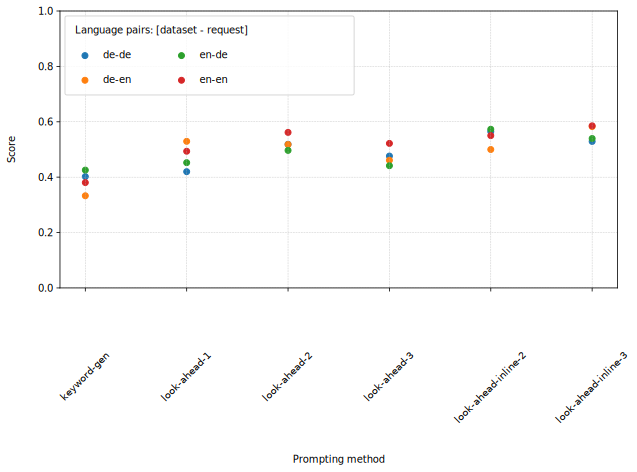

In [ ]:
_penalization : List['float'] = [1]
_dir_eurostat = os.path.join("results", "eurostat", "language")
_result_tests : Dict[str, List['TestResult']]= {_file : pickle.load(open(os.path.join(_dir_eurostat, _file), "rb")) for _file in os.listdir(_dir_eurostat)}
_data : Dict[str, Dict[str, float]] = {}

for _test in _result_tests:
    lang = _test.split('_')[1]
    _source = " : ".join(_test.split('_')[3:4])
    if (lang not in _data):
        _data[lang] = {}
    _result : List['TestResult'] = pickle.load(open(os.path.join(_dir_eurostat, _test), "rb"))
    _data[lang][_source] = np.mean([x.evaluate_score(_penalization) or x.get_score() if isinstance(x, TestResultExtended) else x.get_score() for x in _result])

plt.figure(figsize=(10,5))
plt.ylim(0,1)
for _lang in _data:
    plt.scatter(x=_data[_lang].keys(), y=_data[_lang].values(), label=_lang)

plt.xlabel("Prompting method", labelpad=30)
plt.ylabel("Score", labelpad=20)

title = "Language pairs: [dataset - request]                             " ## dirty trick to make spacing for the title
plt.legend(borderpad=1, loc='upper left', ncols=2, columnspacing=4, alignment='left', title=title, labelspacing=1.5)
plt.xticks(rotation=45, position=(0,-.2))
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [ ]:
print("Testing the difference between the languages:")
print()

print("Values for the language pairs:")
for lang in _data:
    print(f"\t{lang}: {_data[lang].values()}")

H, p_value = stats.kruskal(*[[value for value in _data[lang].values() ]for lang in _data.keys()])

print(f"The Kruskal-Wallis H-test: H = {H:.6f}, p-value = {p_value:.6f}")

print("The null hypothesis that the medians of the groups are equal can be rejected." 
      if p_value < 0.05
      else "The null hypothesis that the medians of the groups are equal cannot be rejected.")

Testing the difference between the languages:

Values for the language pairs:
	de-de: dict_values([0.40212454212454213, 0.41984515484515483, 0.5187229437229438, 0.47618817585922857, 0.5645959595959595, 0.5289597902097902])
	de-en: dict_values([0.33280727442492153, 0.5294098222039398, 0.5180376640902956, 0.4610775335775335, 0.49989898989898984, 0.5827525252525253])
	en-de: dict_values([0.42554029304029306, 0.45237262737262735, 0.4966491841491842, 0.4413118022328549, 0.572907647907648, 0.539570707070707])
	en-en: dict_values([0.380487012987013, 0.4935761340109167, 0.5615792540792541, 0.5218681318681319, 0.5500668449197861, 0.5854767454767454])
The Kruskal-Wallis H-test: H = 1.086667, p-value = 0.780294
The null hypothesis that the medians of the groups are equal cannot be rejected.


### <a id='toc1_4_2_'></a>[Look-Ahead Trends (Tabbed)](#toc0_)

Values:
	Eurostat: dict_values([0.4025030525030525, 0.5012696192696193, 0.5222055395584807, 0.5038677988677989])
	Filesystem: dict_values([0.27474747474747474, 0.30644271664008504, 0.42324119979399477, 0.5406887181323272])
	Mean:  [0.33862526 0.40385617 0.47272337 0.52227826]


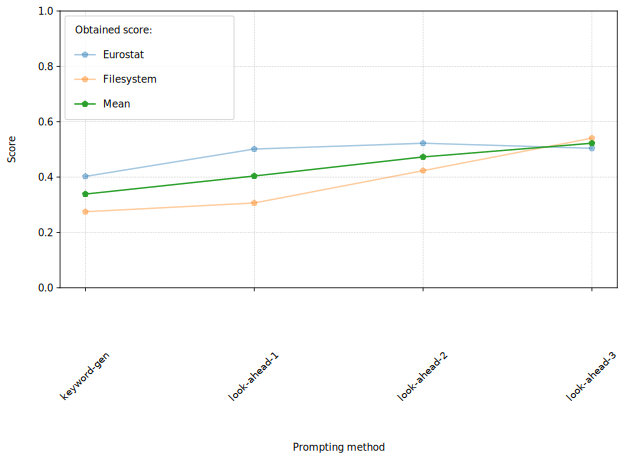

In [ ]:
_dir_eurostat = os.path.join("results", "eurostat", "penalization")
_dir_filesystem = os.path.join("results", "filesystem", "penalization")
_result_tests_eurostat : Dict[str, List['TestResultExtended']] = { _file : pickle.load(open(os.path.join(_dir_eurostat, _file), "rb")) for _file in os.listdir(_dir_eurostat)}
_result_tests_filesystem : Dict[str, List['TestResultExtended']] = { _file : pickle.load(open(os.path.join(_dir_filesystem, _file), "rb")) for _file in os.listdir(_dir_filesystem)}

_data : Dict[str, Dict[str, float]] = {}
_tokens : Dict[str, Dict[str, float]] = {}
_x_ticks : List[str] = []

for (_dir, _tests, _label) in [
        (_dir_eurostat, _result_tests_eurostat, "Eurostat"),
        (_dir_filesystem, _result_tests_filesystem, "Filesystem"),
    ]:
    _data[_label] = {}
    _tokens[_label] = {}
    for _test in _tests:
        _type = _test.split('_')[3]
        _result : List['TestResultExtended'] = pickle.load(open(os.path.join(_dir, _test), "rb"))
        _data[_label][_type] = np.mean([x.get_score() for x in _result])
        _tokens[_label][_type] = np.mean([x.tokens_used for x in _result])

_x_ticks = _data["Eurostat"].keys()
_mean_score_tabbed : np.ndarray = (np.array([_data["Eurostat"][key] for key in _data["Eurostat"]]) + np.array([_data["Filesystem"][key] for key in _data["Filesystem"]]))/2
_mean_tokens_tabbed : np.ndarray = (np.array([_tokens["Eurostat"][key] for key in _tokens["Eurostat"]]) + np.array([_tokens["Filesystem"][key] for key in _tokens["Filesystem"]]))/2

plt.figure(figsize=(10,5))
plt.xlabel('Prompting method', labelpad=40)
plt.ylabel('Score', labelpad=20)

for _label in _data:
    plt.plot(_data[_label].keys(), _data[_label].values(), '-p', label=_label, alpha=0.4)
plt.plot(_mean_score_tabbed, '-p', label="Mean", alpha=1)
title = "Obtained score:                      "
plt.legend(loc='upper left', borderpad=1, alignment='left', labelspacing=1.5, title=title)
plt.ylim([0,1])
    
print("Values:")
for lang in _data:
    print(f"\t{lang}: {_data[lang].values()}")
print("\tMean: ", _mean_score_tabbed)

plt.xticks(rotation=45, position=(0,-.2))
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

### <a id='toc1_4_3_'></a>[Look-Ahead Trends (Inline)](#toc0_)

Values:
	Eurostat: dict_values([0.4025030525030525, 0.5012696192696193, 0.5481164887743836, 0.5596843434343434])
	Filesystem: dict_values([0.27474747474747474, 0.30644271664008504, 0.48120607217245864, 0.5245409702342476])
	Mean:  [0.33862526 0.40385617 0.51466128 0.54211266]


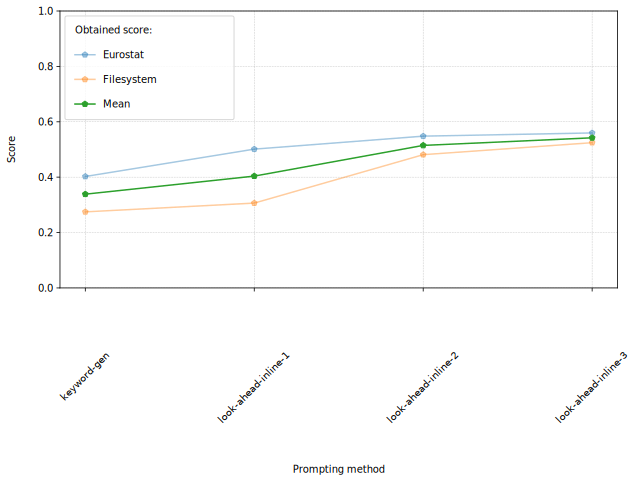

In [ ]:
_dir_eurostat = os.path.join("results", "eurostat", "penalization-inline")
_dir_filesystem = os.path.join("results", "filesystem", "penalization-inline")
_result_tests_eurostat : Dict[str, List['TestResultExtended']] = { _file : pickle.load(open(os.path.join(_dir_eurostat, _file), "rb")) for _file in os.listdir(_dir_eurostat)}
_result_tests_filesystem : Dict[str, List['TestResultExtended']] = { _file : pickle.load(open(os.path.join(_dir_filesystem, _file), "rb")) for _file in os.listdir(_dir_filesystem)}

_data : Dict[str, Dict[str, float]] = {}
_tokens : Dict[str, Dict[str, float]] = {}

for (_dir, _tests, _label) in [
        (_dir_eurostat, _result_tests_eurostat, "Eurostat"),
        (_dir_filesystem, _result_tests_filesystem, "Filesystem"),
    ]:
    _data[_label] = {}
    _tokens[_label] = {}
    for _test in _tests:
        _type = _test.split('_')[3]
        _result : List['TestResultExtended'] = pickle.load(open(os.path.join(_dir, _test), "rb"))
        _data[_label][_type] = np.mean([x.get_score() for x in _result])
        _tokens[_label][_type] = np.mean([x.tokens_used for x in _result])

## create mean result records
_mean_score_inline : np.ndarray = (np.array([_data["Eurostat"][key] for key in _data["Eurostat"]]) + np.array([_data["Filesystem"][key] for key in _data["Filesystem"]]))/2
_mean_tokens_inline : np.ndarray = (np.array([_tokens["Eurostat"][key] for key in _tokens["Eurostat"]]) + np.array([_tokens["Filesystem"][key] for key in _tokens["Filesystem"]]))/2

plt.figure(figsize=(10,5))
plt.xlabel('Prompting method', labelpad=40)
plt.ylabel('Score', labelpad=20)

for _label in _data:
    plt.plot(_data[_label].keys(), _data[_label].values(), '-p', label=_label, alpha=0.4)
plt.plot(_mean_score_inline, '-p', label="Mean", alpha=1)
title = "Obtained score:                      "
plt.legend(loc='upper left', borderpad=1, alignment='left', labelspacing=1.5, title=title)
plt.ylim([0,1])

print("Values:")
for lang in _data:
    print(f"\t{lang}: {_data[lang].values()}")
print("\tMean: ", _mean_score_inline)

plt.xticks(rotation=45, position=(0,-.2))
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

### <a id='toc1_4_4_'></a>[Token size trend](#toc0_)

Values: 
	Inline: [ 1144.63571429  1191.02857143  2781.69285714 12208.62142857]
	Tabbed: [ 1144.63571429  1191.02857143  3204.61428571 15808.3       ]


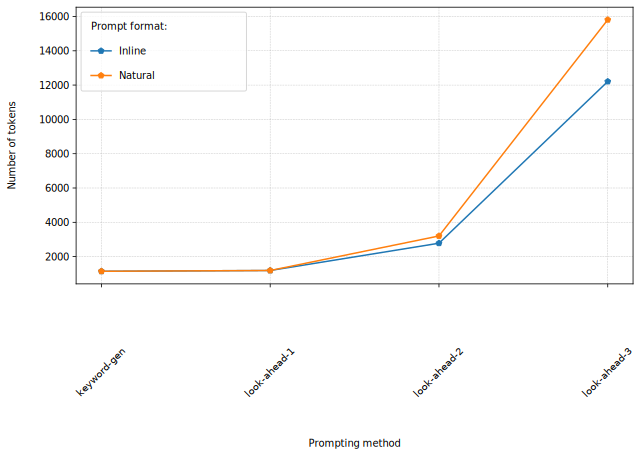

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('Prompting method', labelpad=40)
plt.ylabel('Number of tokens', labelpad=20)

plt.plot(_x_ticks, _mean_tokens_inline, '-p', label="Inline", alpha=1)
plt.plot(_x_ticks, _mean_tokens_tabbed, '-p', label="Natural", alpha=1)
title = "Prompt format:                      "
plt.legend(loc='upper left', borderpad=1, alignment='left', labelspacing=1.5, title=title)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

print("Values: ")
print(f"\tInline: {_mean_tokens_inline}")
print(f"\tTabbed: {_mean_tokens_tabbed}")

plt.xticks(rotation=45, position=(0,-.2))
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

### <a id='toc1_4_5_'></a>[Trend model-invariation](#toc0_)

Values:
	gpt-3.5-turbo-0125: dict_values([0.3252093902829197, 0.4317866081491199, 0.4960924356144944, 0.5681862362783415, 0.5016949540827251, 0.5191700701259524])
	gpt-4-0125-preview: dict_values([0.6623015873015873, 0.8305648055648055, 0.9034391534391535, 0.920486111111111, 0.7947222222222222, 0.7875198412698412])


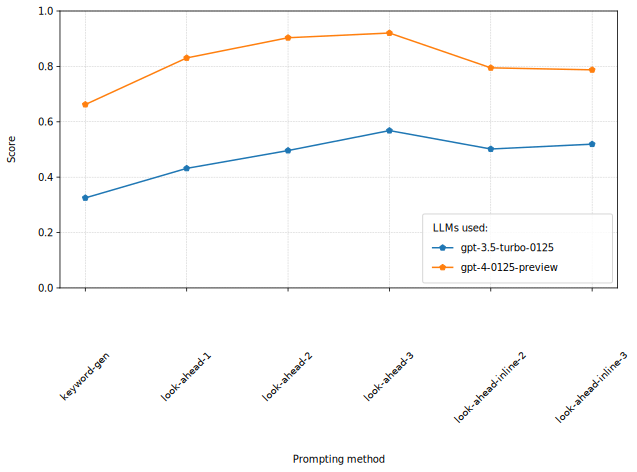

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

_dir_eurostat = os.path.join("results", "eurostat", "model-compare")
_dir_filesystem = os.path.join("results", "filesystem", "model-compare")
_result_tests_eurostat : Dict[str, List['TestResult']] = { _file : pickle.load(open(os.path.join(_dir_eurostat, _file), "rb")) for _file in os.listdir(_dir_eurostat)}
_result_tests_filesystem : Dict[str, List['TestResult']] = { _file : pickle.load(open(os.path.join(_dir_filesystem, _file), "rb")) for _file in os.listdir(_dir_filesystem)}

_data : Dict[str, Dict[str, float]] = {}

for (_dir, _tests) in [
        (_dir_eurostat, _result_tests_eurostat),
        (_dir_filesystem, _result_tests_filesystem)
    ]:
    for _test in _tests:
        _type = _test.split('_')[2]
        _label = _test.split('_')[1]
        if (_label not in _data):
            _data[_label] = {}
        _result : List['TestResult'] = pickle.load(open(os.path.join(_dir, _test), "rb"))
        if (_type not in _data[_label]):
            _data[_label][_type] = np.array([x.get_score() for x in _result])
        else:
            _data[_label][_type] = np.concatenate((_data[_label][_type], np.array([x.get_score() for x in _result])))
    
for _label in _data:
    for _type in _data[_label]:
        _data[_label][_type] = np.mean(_data[_label][_type], axis=0)
    
plt.figure(figsize=(10,5))
plt.ylim(0,1)

## create different plots for each label
_diffs : List[tuple[str, tuple[float, float]]] = []
label_names = list(_data.keys())
test_names = list(_data[label_names[0]].keys())
for i in range(len(test_names)):
    _diffs.append((test_names[i], tuple([_data[label][test_names[i]] for label in label_names])))

for _label in _data:
    plt.plot(_data[_label].keys(), _data[_label].values(), '-p', label=_label)

plt.xlabel("Prompting method", labelpad=30)
plt.ylabel("Score", labelpad=20)

print("Values:")
for lang in _data:
    print(f"\t{lang}: {_data[lang].values()}")

title = "LLMs used:                                    "
plt.legend(borderpad=1, loc='lower right', ncol=1, labelspacing=1, title=title, alignment='left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(rotation=45, position=(0,-.2))
plt.show()

In [ ]:
from scipy import stats

print("Measured score for single tests: [GPT-3 ; GPT-4]")
_result_names = [x[0] for x in _diffs]
_results_a = [x[1][0] for x in _diffs]
_results_b = [x[1][1] for x in _diffs]

for i in range(len(_result_names)):
    print(f"{_result_names[i]}:")
    print(f"\t{_results_a[i]:.6f} ; {_results_b[i]:.6f}")

print()
print("The Shapiro-Wilk test:")
shapiro_test = stats.shapiro([y - x for x, y in zip(_results_a, _results_b)])

print(f"Statistic: {shapiro_test.statistic:.6f}, p-value: {shapiro_test.pvalue:.6f}")
print("The null hypothesis that the data was drawn from a normal distribution can be rejected." 
      if shapiro_test.pvalue < 0.05 
      else "The null hypothesis that the data was drawn from a normal distribution cannot be rejected.")

Measured score for single tests: [GPT-3 ; GPT-4]
keyword-gen:
	0.325209 ; 0.662302
look-ahead-1:
	0.431787 ; 0.830565
look-ahead-2:
	0.496092 ; 0.903439
look-ahead-3:
	0.568186 ; 0.920486
look-ahead-inline-2:
	0.501695 ; 0.794722
look-ahead-inline-3:
	0.519170 ; 0.787520

The Shapiro-Wilk test:
Statistic: 0.938679, p-value: 0.648577
The null hypothesis that the data was drawn from a normal distribution cannot be rejected.


In [ ]:
print("Intermodel differences: [GPT-3 ; GPT-4]")
_result_names = [x[0] for x in _diffs]
_results_a = [x[1][0] for x in _diffs]
_results_b = [x[1][1] for x in _diffs]
_inter_diffs_a = [j - i for i, j in zip(_results_a[:-1], _results_a[1:])]
_inter_diffs_b = [j - i for i, j in zip(_results_b[:-1], _results_b[1:])]

print(_inter_diffs_a)
print(_inter_diffs_b)

for idx in range(len(_result_names)):
    if (idx < len(_result_names) - 1):
        print(f"{idx}:")    
        print(f"  {_inter_diffs_a[idx]:.3f} ; {_inter_diffs_b[idx]:.3f}")

paired_t_test = stats.ttest_rel(_inter_diffs_a, _inter_diffs_b)

print()
print("The paired t-test:")
print(f"Statistic: {paired_t_test.statistic:.6f}, p-value: {paired_t_test.pvalue:.6f}")
print("The null hypothesis that the models have the same performance can be rejected." 
      if paired_t_test.pvalue < 0.05 
      else "The null hypothesis that the models have the same performance cannot be rejected.")

Intermodel differences: [GPT-3 ; GPT-4]
[0.10657721786620022, 0.0643058274653745, 0.07209380066384713, -0.0664912821956164, 0.017475116043227268]
[0.16826321826321822, 0.07287434787434799, 0.01704695767195752, -0.1257638888888888, -0.007202380952381016]
0:
  0.107 ; 0.168
1:
  0.064 ; 0.073
2:
  0.072 ; 0.017
3:
  -0.066 ; -0.126
4:
  0.017 ; -0.007

The paired t-test:
Statistic: 0.612228, p-value: 0.573479
The null hypothesis that the models have the same performance cannot be rejected.


### <a id='toc1_4_6_'></a>[Error location penalization](#toc0_)

Values:
	eurostat_unpenalized: dict_values([0.4025030525030525, 0.5012696192696193, 0.5222055395584807, 0.5038677988677989])
	eurostat_penalized: dict_values([0.416296730499662, 0.4685384524760792, 0.5473392569588221, 0.5364429944724063])
	filesystem_unpenalized: dict_values([0.27474747474747474, 0.30644271664008504, 0.42324119979399477, 0.5406887181323272])
	filesystem_penalized: dict_values([0.24970496735249034, 0.2851451057818462, 0.4054604091682979, 0.5392335312611547])
Diff: 
	Eurostat: [-0.01379368  0.03273117 -0.02513372 -0.0325752 ]
	Filesystem: [0.02504251 0.02129761 0.01778079 0.00145519]


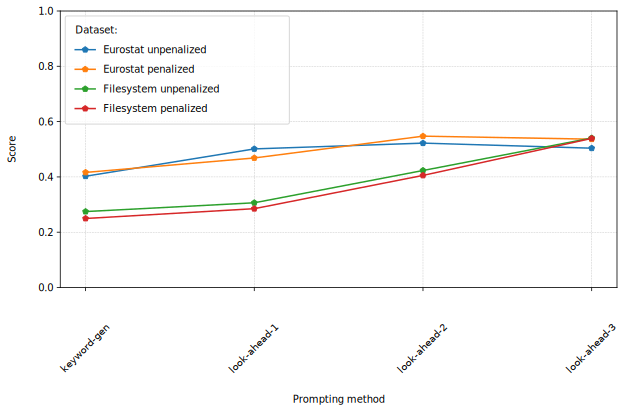

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

_penalization : List[float] = [2.0, 1.0, 0.5]

_dir_eurostat = os.path.join("results", "eurostat", "penalization")
_dir_filesystem = os.path.join("results", "filesystem", "penalization")
_result_tests_eurostat_unpenalized : Dict[str, List['TestResultExtended']] = { _file : pickle.load(open(os.path.join(_dir_eurostat, _file), "rb")) for _file in os.listdir(_dir_eurostat)}
_result_tests_filesystem_unpenalized : Dict[str, List['TestResultExtended']] = { _file : pickle.load(open(os.path.join(_dir_filesystem, _file), "rb")) for _file in os.listdir(_dir_filesystem)}
_result_tests_eurostat_penalized : Dict[str, List['TestResultExtended']] = { _file : pickle.load(open(os.path.join(_dir_eurostat, _file), "rb")) for _file in os.listdir(_dir_eurostat)}
_result_tests_filesystem_penalized : Dict[str, List['TestResultExtended']] = { _file : pickle.load(open(os.path.join(_dir_filesystem, _file), "rb")) for _file in os.listdir(_dir_filesystem)}

_data : Dict[str, Dict[str, float]] = {}

for (_dir, _tests, _label) in [
        (_dir_eurostat, _result_tests_eurostat_unpenalized, "eurostat_unpenalized"),
        (_dir_eurostat, _result_tests_eurostat_penalized, "eurostat_penalized"),
        (_dir_filesystem, _result_tests_filesystem_unpenalized, "filesystem_unpenalized"),
        (_dir_filesystem, _result_tests_filesystem_penalized, "filesystem_penalized")
    ]:
    _data[_label] = {}
    for _test in _tests:
        _type = _test.split('_')[3]
        _result : List['TestResultExtended'] = pickle.load(open(os.path.join(_dir, _test), "rb"))
        if ("unpenalized" in _label):
            _data[_label][_type] = np.mean([x.get_score() for x in _result])
        else:
            _data[_label][_type] = np.mean([x.evaluate_score(_penalization) or x.get_score() for x in _result])
    
plt.figure(figsize=(10,5))
plt.ylim(0,1)

for _label in _data:
    plt.plot(_data[_label].keys(), _data[_label].values(), '-p', label=_label.capitalize().replace("_"," "))

## create different plots for unpenalized and penalized
_values : Dict[str, List[float]] = {
    "unpenalized" : [],
    "penalized" : []
}

for _label in _data:
    for _type in _data[_label]:
        if ("unpenalized" in _label):
            _values["unpenalized"].append(_data[_label][_type])
        else:
            _values["penalized"].append(_data[_label][_type])


plt.xlabel("Prompting method", labelpad=20)
plt.ylabel("Score", labelpad=20)

print("Values:")
for lang in _data:
    print(f"\t{lang}: {_data[lang].values()}")
print("Diff: ")
print(f"\tEurostat: {np.array(_values["unpenalized"][:len(_values["unpenalized"])//2])-np.array(_values["penalized"][:len(_values["penalized"])//2])}")
print(f"\tFilesystem: {np.array(_values["unpenalized"][len(_values["unpenalized"])//2:])-np.array(_values["penalized"][len(_values["penalized"])//2:])}")


title = "Dataset:                                                   "
plt.legend(loc='upper left', borderpad=1, title=title, labelspacing=1, alignment='left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(rotation=45, position=(0,-.1))
plt.show()

In [ ]:
from scipy import stats
import numpy as np

print("Checking if data are drawn from normal distribution:")
print()

_values_unpenalized = np.array(_values["unpenalized"])
_values_penalized = np.array(_values["penalized"])

print("The Shapiro-Wilk test:")
shapiro_test = stats.shapiro(_values_penalized - _values_unpenalized)
print(f"Statistic: {shapiro_test.statistic:.6f}, p-value: {shapiro_test.pvalue:.6f}")
print()

print("The null hypothesis that the data was drawn from a normal distribution can be rejected." 
      if shapiro_test.pvalue < 0.05 
      else """The null hypothesis that the data was drawn from a normal distribution cannot be rejected.""")

Checking if data are drawn from normal distribution:

The Shapiro-Wilk test:
Statistic: 0.914780, p-value: 0.388954

The null hypothesis that the data was drawn from a normal distribution cannot be rejected.


In [ ]:
print("Testing whether the penalization has an effect on the model performance")
print()

paired_t_test = stats.ttest_rel(_values_unpenalized, _values_penalized)
print("The paired t-test:")
print(f"Statistic: {paired_t_test.statistic:.6f}, p-value: {paired_t_test.pvalue:.6f}")
print()

print("The null hypothesis that the penalization has no effect on the score can be rejected." 
      if paired_t_test.pvalue < 0.05 
      else "The null hypothesis that the penalization has no effect on the score cannot be rejected.")


Testing whether the penalization has an effect on the model performance

The paired t-test:
Statistic: 0.383995, p-value: 0.712380

The null hypothesis that the penalization has no effect on the score cannot be rejected.
